In [1]:
import os
import pandas as pd
import numpy as np
import sys
import re
import json

import csv
import time
from datetime import date, datetime

print(date.today())
print('Python version:', sys.version)
print('\nWorking directory:', os.getcwd())
os.chdir(r'C:\Users\Denis_Davydov2\OneDrive - EPAM\Prophet_AI_docs\Datasets\AI_skills\Topics')
print('\nCurrent working directory:', os.getcwd())
print("Last run:", date.today())

2025-11-11
Python version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]

Working directory: c:\Users\Denis_Davydov2\OneDrive\Scipts\Py_Scripts\EPAM\Prophet\AI_skills

Current working directory: C:\Users\Denis_Davydov2\OneDrive - EPAM\Prophet_AI_docs\Datasets\AI_skills\Topics
Last run: 2025-11-11


In [56]:

# Load filtered topics with embeddings
file_path = 'C:\\Users\\Denis_Davydov2\\OneDrive - EPAM\\Prophet_AI_docs\\Datasets\\AI_skills\\Topics\\'
file_name = 'ai_topics_final2025-11-10.csv'

topics = pd.read_csv(file_path+file_name)
print("File read: ", file_name)

topics

File read:  ai_topics_final2025-11-10.csv


,id,term,definition,count,similarity_to_AI,consensus_score,embedding_norm
0,6.0,1-bit inference,1-bit inference refers to the process of runni...,2.0,0.280766,4,"[0.013369597494602203, -0.013582168146967888, ..."
1,7.0,1-bit llm,A 1-bit large language model (LLM) is a highly...,5.0,0.220254,4,"[0.017574984580278397, -0.004011554177850485, ..."
2,9.0,1-bit quantization,1-bit quantization is an extreme model compres...,6.0,0.187808,3,"[-0.015226091258227825, 0.0012089560041204095,..."
3,14.0,2-bit quantization,2-bit quantization is a process that reduces t...,4.0,0.190536,4,"[-0.006645898800343275, 0.006167215760797262, ..."
4,17.0,2d animation,"""2D animation"" refers to the use of artificial...",3.0,0.370161,5,"[0.008917991071939468, -0.002153154695406556, ..."
...,...,...,...,...,...,...,...
6966,19003.0,zero-shot voice cloning,Zero-shot voice cloning is the task of synthes...,3.0,0.212219,4,"[-0.007965235970914364, -0.027662577107548714,..."
6967,19007.0,zero-trust security,Zero-trust security for AI/ML is an architectu...,4.0,0.419530,5,"[-0.01758248545229435, 0.059987302869558334, 0..."
6968,19010.0,zero/zero++,"""Zero"" (zero-shot) refers to applying or evalu...",2.0,0.243124,4,"[-0.0007028839900158346, 0.011448170058429241,..."
6969,19012.0,zerogpu,"Zerogpu (often stylized ""zerogpu"") refers to C...",2.0,0.299549,4,"[0.004047493916004896, 0.05906970053911209, 0...."


# Data preparation 

In [57]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def l2_normalize_rows(A, eps=1e-12):
	norms = np.linalg.norm(A, axis=1, keepdims=True)
	norms = np.maximum(norms, eps)
	return A / norms

def dehub_embeddings(topics: pd.DataFrame,
    col: str = 'embedding_norm',
    pca_dim: int = 128,
    drop_pc: int = 1,
    out_col: str = 'embedding_dehub',
    random_state: int = 42) -> pd.DataFrame:
    # Сформировать матрицу (n_samples, d)
    X = np.stack(topics[col].values).astype(np.float32)

    # 1) Вычесть среднее по всем векторам
    mu = X.mean(axis=0, keepdims=True)
    Xc = X - mu

    # Безопасное число компонент PCA (не больше min(n-1, d, pca_dim))
    n_samples, d = Xc.shape
    n_components = max(1, min(pca_dim, d, max(1, n_samples - 1)))

    # 2) PCA до 128 измерений (или меньше, если данных мало)
    pca = PCA(n_components=n_components, random_state=random_state)
    Z = pca.fit_transform(Xc)  # (n_samples, n_components)

    # 3) Удалить 1 первую главную компоненту
    keep_from = min(drop_pc, Z.shape[1])  # на случай, если компонент мало
    Z = Z[:, keep_from:]  # размер станет (n_samples, n_components - drop_pc)

    # 4) Снова L2-нормализация
    Z_norm = l2_normalize_rows(Z) if Z.shape[1] > 0 else Z

    # Сохранить в новый столбец датафрейма
    topics1 = topics.copy()
    topics1[out_col] = list(Z_norm)
    return topics1

In [65]:
# Convert string representations of arrays back to numpy arrays
topics['embedding_norm'] = topics['embedding_norm'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

topics1 = dehub_embeddings(topics, col='embedding_norm', pca_dim=128, drop_pc=1, out_col='embedding_dehub')
topics1

,id,term,definition,count,similarity_to_AI,consensus_score,embedding_norm,embedding_dehub
0,6.0,1-bit inference,1-bit inference refers to the process of runni...,2.0,0.280766,4,"[0.013369597494602203, -0.013582168146967888, ...","[-0.10377315, 0.024112597, -0.37237495, -0.070..."
1,7.0,1-bit llm,A 1-bit large language model (LLM) is a highly...,5.0,0.220254,4,"[0.017574984580278397, -0.004011554177850485, ...","[-0.041667353, -0.1235163, 0.33915088, -0.0217..."
2,9.0,1-bit quantization,1-bit quantization is an extreme model compres...,6.0,0.187808,3,"[-0.015226091258227825, 0.0012089560041204095,...","[-0.052673534, 0.017871799, -0.36147624, -0.01..."
3,14.0,2-bit quantization,2-bit quantization is a process that reduces t...,4.0,0.190536,4,"[-0.006645898800343275, 0.006167215760797262, ...","[-0.05830743, 0.014523482, -0.35151455, 0.0150..."
4,17.0,2d animation,"""2D animation"" refers to the use of artificial...",3.0,0.370161,5,"[0.008917991071939468, -0.002153154695406556, ...","[0.31390756, -0.02592274, -0.26441434, 0.10848..."
...,...,...,...,...,...,...,...,...
6966,19003.0,zero-shot voice cloning,Zero-shot voice cloning is the task of synthes...,3.0,0.212219,4,"[-0.007965235970914364, -0.027662577107548714,...","[0.38904208, 0.0016928717, -0.1268675, -0.0348..."
6967,19007.0,zero-trust security,Zero-trust security for AI/ML is an architectu...,4.0,0.419530,5,"[-0.01758248545229435, 0.059987302869558334, 0...","[-0.24598806, -0.0046496205, 0.06976296, 0.038..."
6968,19010.0,zero/zero++,"""Zero"" (zero-shot) refers to applying or evalu...",2.0,0.243124,4,"[-0.0007028839900158346, 0.011448170058429241,...","[0.057271093, 0.020468256, -0.22577171, -0.227..."
6969,19012.0,zerogpu,"Zerogpu (often stylized ""zerogpu"") refers to C...",2.0,0.299549,4,"[0.004047493916004896, 0.05906970053911209, 0....","[-0.20782912, -0.43594316, -0.291142, -0.16293..."


# Clustering

## Graph + Leiden clustering

In [61]:
# Превращаем колонку списков в матрицу X (n_samples, n_features)
# Если данные сохранены как строки, конвертируем их обратно в массивы
emb_col = 'embedding_norm'
if isinstance(topics1[emb_col].iloc[0], str):
    import ast
    topics1[emb_col] = topics1[emb_col].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)

X = np.vstack(topics1[emb_col].values).astype(np.float32)
n_samples, n_features = X.shape
print(f"X shape: {X.shape}")  # Ожидается (6971, 1536)

X shape: (6971, 1536)


In [62]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter, defaultdict


def build_mutual_knn_graph(
    X,
    k=30,
    weighting="jaccard",  # 'jaccard' или 'selftuned'
    local_k_sigma=7,      # для self-tuning: порядковый сосед для sigma_i
    metric="cosine",
    ensure_min_degree: bool = True,  # добавлять минимум одно ребро изолированным вершинам
    min_degree_weight: float = 1e-6, # вес для добавочных ребер (минимальное влияние)
):
    """
    Строит взаимный kNN-граф (mutual kNN) по косинусной близости и возвращает igraph.Graph.
    Усиление для уменьшения числа одиночек: если ensure_min_degree=True, то вершины
    без взаимных соседей получают ребро к своему ближайшему соседу с маленьким весом.

    Параметры:
      k: число соседей для поиска (увеличить до 40 по умолчанию для более плотного графа)
      weighting: 'jaccard' (робастно) или 'selftuned' (локальное масштабирование)
      ensure_min_degree: подключать изолированные вершины к 1-му соседу
      min_degree_weight: вес добавочных ребер (очень малый, чтобы не исказить структуру)
    """
    import igraph as ig

    n = X.shape[0]
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric)
    nn.fit(X)
    dists, inds = nn.kneighbors(X)  # dists: косинусная дистанция (1 - cos sim)
    # Убираем self
    dists = dists[:, 1:]
    inds = inds[:, 1:]

    neighbor_sets = [set(row) for row in inds]
    # Для self-tuning заранее подготовим словари дистанций
    if weighting.lower() in ("selftuned", "self_tuned", "local"):
        dist_dicts = [dict(zip(inds[i], dists[i])) for i in range(n)]
        ksig = max(1, min(local_k_sigma, inds.shape[1]))
        sigma = dists[:, ksig - 1].copy()
        sigma = np.maximum(sigma, 1e-12)
    else:
        dist_dicts = None
        sigma = None

    edges = []
    weights = []

    for i in range(n):
        Ni = neighbor_sets[i]
        for j in inds[i]:
            if i < j and (i in neighbor_sets[j]):  # взаимный kNN
                if weighting == "jaccard":
                    Nj = neighbor_sets[j]
                    inter = len(Ni & Nj)
                    union = len(Ni | Nj)
                    w = inter / union if union > 0 else 0.0
                else:
                    # self-tuning на косинусной дистанции
                    dij = dist_dicts[i].get(j, None)
                    dji = dist_dicts[j].get(i, None)
                    if dij is None and dji is None:
                        xi = X[i]
                        xj = X[j]
                        num = float(xi @ xj)
                        denom = float(np.linalg.norm(xi) * np.linalg.norm(xj)) + 1e-12
                        d = 1.0 - num / denom
                    else:
                        if dij is None:
                            dij = dji
                        if dji is None:
                            dji = dij
                        d = 0.5 * (dij + dji)
                    w = float(np.exp(-(d * d) / (sigma[i] * sigma[j])))

                if w > 0.0:
                    edges.append((i, j))
                    weights.append(float(w))

    # Добавляем минимальные ребра для изолированных вершин (уменьшаем одиночки)
    if ensure_min_degree:
        current_degrees = defaultdict(int)
        for (a, b) in edges:
            current_degrees[a] += 1
            current_degrees[b] += 1
        for i in range(n):
            if current_degrees[i] == 0:
                j = inds[i][0]
                if i == j:
                    continue
                e = (i, j) if i < j else (j, i)
                if e not in edges:
                    edges.append(e)
                    weights.append(float(min_degree_weight))

    g = ig.Graph()
    g.add_vertices(n)
    if edges:
        g.add_edges(edges)
        g.es["weight"] = weights
    return g


def run_leiden_over_resolutions(
    g,
    resolutions=(0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.3, 1.6, 2.0),
    seed=42,
    n_iterations=-1  # -1 = до сходимости
):
    import numpy as np
    import leidenalg as la
    parts = {}
    weights = g.es["weight"] if g.ecount() > 0 and "weight" in g.es.attributes() else None
    for res in resolutions:
        part = la.find_partition(
            g,
            la.RBConfigurationVertexPartition,
            weights=weights,
            resolution_parameter=float(res),
            seed=seed,
            n_iterations=n_iterations,
        )
        parts[float(res)] = np.array(part.membership, dtype=int)
    return parts


def summarize_partitions(parts):
    summaries = {}
    for res, labels in parts.items():
        cnt = Counter(labels)
        sizes = np.fromiter(cnt.values(), dtype=int)
        summaries[res] = {
            "n_clusters": int(len(cnt)),
            "n_singletons": int(np.sum(sizes == 1)),
            "min_size": int(sizes.min() if len(sizes) else 0),
            "median_size": float(np.median(sizes) if len(sizes) else 0.0),
            "max_size": int(sizes.max() if len(sizes) else 0),
        }
    return summaries


def partition_stability(parts):
    from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
    res_list = sorted(parts.keys())
    stab = {}
    for i in range(len(res_list) - 1):
        r1, r2 = res_list[i], res_list[i + 1]
        l1, l2 = parts[r1], parts[r2]
        stab[(r1, r2)] = {
            "NMI": float(normalized_mutual_info_score(l1, l2)),
            "ARI": float(adjusted_rand_score(l1, l2)),
        }
    return stab


def refinement_map(coarse_labels, fine_labels, min_frac=0.0):
    """Отображение: кластер coarse -> разбиение на кластеры fine (и их доли)."""
    n = len(coarse_labels)
    mapping = defaultdict(Counter)
    for i in range(n):
        mapping[coarse_labels[i]][fine_labels[i]] += 1
    out = {}
    for c, cnt in mapping.items():
        total = sum(cnt.values())
        fracs = {f: v / total for f, v in cnt.items() if v / total >= min_frac}
        out[c] = dict(sorted(fracs.items(), key=lambda kv: -kv[1]))
    return out


def suggest_resolution(parts, max_singletons_ratio=0.02, min_median_size=10):
    """
    Эвристика выбора resolution для МЕНЬШЕГО числа одиночек и БОЛЬШИХ кластеров.
    Логика:
      1. Формируем список кандидатов, проходящих пороги (доля одиночек <= max_singletons_ratio, медиана >= min_median_size).
      2. Если есть кандидаты -> выбираем с минимальной долей одиночек; при равенстве — с большей медианой.
      3. Если кандидатов нет -> глобально выбираем resolution с минимальной долей одиночек; при равенстве — с большей медианой.
    Возвращаем словарь с ключами: 'suggested', 'summaries', 'stability'.
    """
    summaries = summarize_partitions(parts)
    stab = partition_stability(parts)
    res_list = sorted(parts.keys())
    candidates = []
    for r in res_list:
        sm = summaries[r]
        singletons_ratio = sm["n_singletons"] / len(parts[r])
        if singletons_ratio <= max_singletons_ratio and sm["median_size"] >= min_median_size:
            candidates.append((r, singletons_ratio, sm["median_size"]))

    def pick_best(seq):
        return min(seq, key=lambda t: (t[1], -t[2]))

    if candidates:
        suggested = pick_best(candidates)[0]
    else:
        all_seq = [(r, summaries[r]["n_singletons"] / len(parts[r]), summaries[r]["median_size"]) for r in res_list]
        suggested = pick_best(all_seq)[0]

    return {"suggested": suggested, "summaries": summaries, "stability": stab}

In [63]:
# 1) Граф mutual kNN с Jaccard-весами (робастно к шуму)
g = build_mutual_knn_graph(X, k=20, weighting="jaccard")



#2) Leiden по сетке resolution (включая 2.0)
parts = run_leiden_over_resolutions(g, resolutions=(0.5, 1.0, 1.5, 2.0, 2.5, 3.0), seed=42)
parts

#3) Диагностика и выбор уровня
diag = suggest_resolution(parts)  # diag['suggested'] — рекомендуемое resolution
summaries = diag["summaries"]
stability = diag["stability"]

# 4) “Иерархия”: как кластеры дробятся при повышении resolution
# пример: связь между 1.5 и 2.0
hier_15_20 = refinement_map(parts[1.5], parts[2.0], min_frac=0.05)
hier_15_20

# 5) Итоговые метки для resolution=2.0 (или diag['suggested'])
labels_r2 = parts[2.0]
labels_r2

array([27, 72, 27, ..., 52, 10, 48], shape=(6971,))

In [63]:
# Graph + Leiden clustering execution tuned for larger clusters and fewer singletons
import time

t0 = time.time()
k = min(50, X.shape[0]-1) if X.shape[0] > 1 else 1  # повышаем k для более плотного графа

#g = build_mutual_knn_graph(X, k=k, weighting="jaccard", ensure_min_degree=True)    # 'jaccard' (робастно) 
g = build_mutual_knn_graph(X, k=k, weighting="selftuned", ensure_min_degree=True)   # 'selftuned' (локальное масштабирование)


print(f"Graph built: {g.vcount()} nodes, {g.ecount()} edges (k={k})")

# Более плотная сетка низких resolution для крупных кластеров
#resolutions = (0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.3, 1.6, 2.0)
#resolutions = (1.5, 2.0, 2.2, 2.5, 2.7, 3.0, 3.5, 4.0)
resolutions = (8.0, 9.0)
parts = run_leiden_over_resolutions(g, resolutions=resolutions, seed=42)
print("Resolutions computed:", list(parts.keys()))

diag = suggest_resolution(parts, max_singletons_ratio=0.02, min_median_size=10)
suggested = diag["suggested"]
print(f"Suggested resolution (min singletons, max median): {suggested}")

# Cluster summaries
for r, sm in diag["summaries"].items():
    sing_ratio = sm["n_singletons"] / len(parts[r])
    print(f"r={r}: clusters={sm['n_clusters']}, median={sm['median_size']}, max={sm['max_size']}, singletons={sm['n_singletons']}, ({sing_ratio:.3%})")

# Optional hierarchy example between closest lower resolution and suggested
lower_res = max([r for r in parts.keys() if r < suggested], default=None)
if lower_res is not None and suggested in parts:
    hier_low_sug = refinement_map(parts[lower_res], parts[suggested], min_frac=0.05)
    print(f"Hierarchy {lower_res} → {suggested} (first 5 splits):", list(hier_low_sug.items())[:5])

label_col = f"cluster_{suggested}"
topics1[label_col] = parts[suggested]
print(f"Added column '{label_col}' to topics.")

elapsed = time.time() - t0
print(f"Clustering pipeline completed in {elapsed:.2f}s")


print(f'\nTop 10 clusters by size for {label_col}:')
print(counts.head(10))

Graph built: 6971 nodes, 92766 edges (k=50)
Resolutions computed: [8.0, 9.0]
Suggested resolution (min singletons, max median): 8.0
r=8.0: clusters=139, median=47.0, max=123, singletons=0, (0.000%)
r=9.0: clusters=148, median=45.0, max=121, singletons=0, (0.000%)
Added column 'cluster_8.0' to topics.
Clustering pipeline completed in 2.60s

Top 10 clusters by size for cluster_8.0:
0    123
1    117
2    106
3    102
4    101
5     99
6     98
7     96
8     95
9     93
Name: count, dtype: int64
Resolutions computed: [8.0, 9.0]
Suggested resolution (min singletons, max median): 8.0
r=8.0: clusters=139, median=47.0, max=123, singletons=0, (0.000%)
r=9.0: clusters=148, median=45.0, max=121, singletons=0, (0.000%)
Added column 'cluster_8.0' to topics.
Clustering pipeline completed in 2.60s

Top 10 clusters by size for cluster_8.0:
0    123
1    117
2    106
3    102
4    101
5     99
6     98
7     96
8     95
9     93
Name: count, dtype: int64


In [64]:
topics1

,id,term,definition,count,similarity_to_AI,consensus_score,embedding_norm,embedding_dehub,cluster_8.0
0,6.0,1-bit inference,1-bit inference refers to the process of runni...,2.0,0.280766,4,"[0.013369597494602203, -0.013582168146967888, ...","[-0.10377315, 0.024112597, -0.37237495, -0.070...",7
1,7.0,1-bit llm,A 1-bit large language model (LLM) is a highly...,5.0,0.220254,4,"[0.017574984580278397, -0.004011554177850485, ...","[-0.041667353, -0.1235163, 0.33915088, -0.0217...",7
2,9.0,1-bit quantization,1-bit quantization is an extreme model compres...,6.0,0.187808,3,"[-0.015226091258227825, 0.0012089560041204095,...","[-0.052673534, 0.017871799, -0.36147624, -0.01...",7
3,14.0,2-bit quantization,2-bit quantization is a process that reduces t...,4.0,0.190536,4,"[-0.006645898800343275, 0.006167215760797262, ...","[-0.05830743, 0.014523482, -0.35151455, 0.0150...",7
4,17.0,2d animation,"""2D animation"" refers to the use of artificial...",3.0,0.370161,5,"[0.008917991071939468, -0.002153154695406556, ...","[0.31390756, -0.02592274, -0.26441434, 0.10848...",28
...,...,...,...,...,...,...,...,...,...
6966,19003.0,zero-shot voice cloning,Zero-shot voice cloning is the task of synthes...,3.0,0.212219,4,"[-0.007965235970914364, -0.027662577107548714,...","[0.38904208, 0.0016928717, -0.1268675, -0.0348...",90
6967,19007.0,zero-trust security,Zero-trust security for AI/ML is an architectu...,4.0,0.419530,5,"[-0.01758248545229435, 0.059987302869558334, 0...","[-0.24598806, -0.0046496205, 0.06976296, 0.038...",90
6968,19010.0,zero/zero++,"""Zero"" (zero-shot) refers to applying or evalu...",2.0,0.243124,4,"[-0.0007028839900158346, 0.011448170058429241,...","[0.057271093, 0.020468256, -0.22577171, -0.227...",90
6969,19012.0,zerogpu,"Zerogpu (often stylized ""zerogpu"") refers to C...",2.0,0.299549,4,"[0.004047493916004896, 0.05906970053911209, 0....","[-0.20782912, -0.43594316, -0.291142, -0.16293...",90


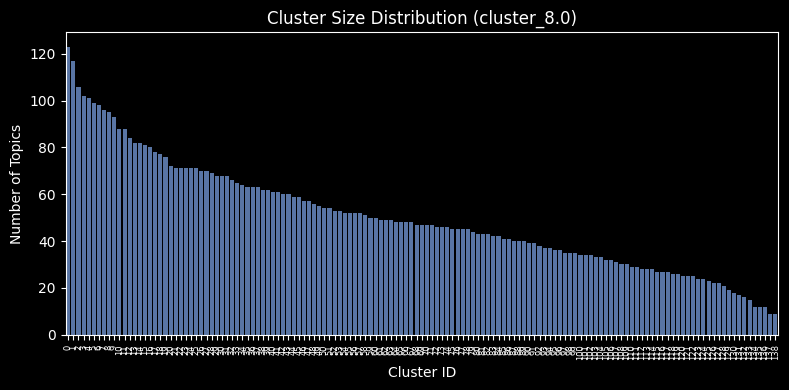

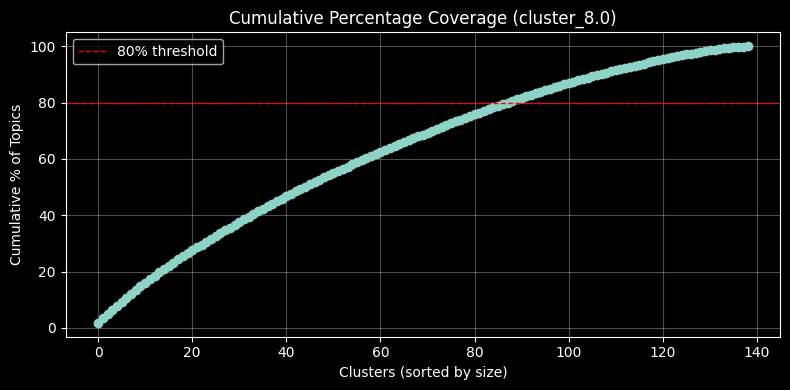

Intra-cluster consistency for cluster_8.0:
  Lower avg_distance => tighter (more consistent) cluster
  Mean avg_distance across all clusters: 0.6271
  Median avg_distance: 0.6371

Top 10 most consistent (smallest avg_distance) clusters:
     cluster  size  avg_distance  std_distance
21        21    71      0.789613      0.173341
49        49    55      0.791950      0.183800
112      112    28      0.792516      0.230016
64        64    48      0.793705      0.215831
90        90    39      0.797563      0.231693
38        38    62      0.807980      0.183807
88        88    40      0.824032      0.242114
4          4   101      0.832443      0.163288
20        20    72      0.842722      0.197316
85        85    41      0.844147      0.190563


C:\Users\Denis_Davydov2\AppData\Local\Temp\ipykernel_7076\1896289526.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_consistency, x='cluster', y='avg_distance', ax=ax, palette='viridis')


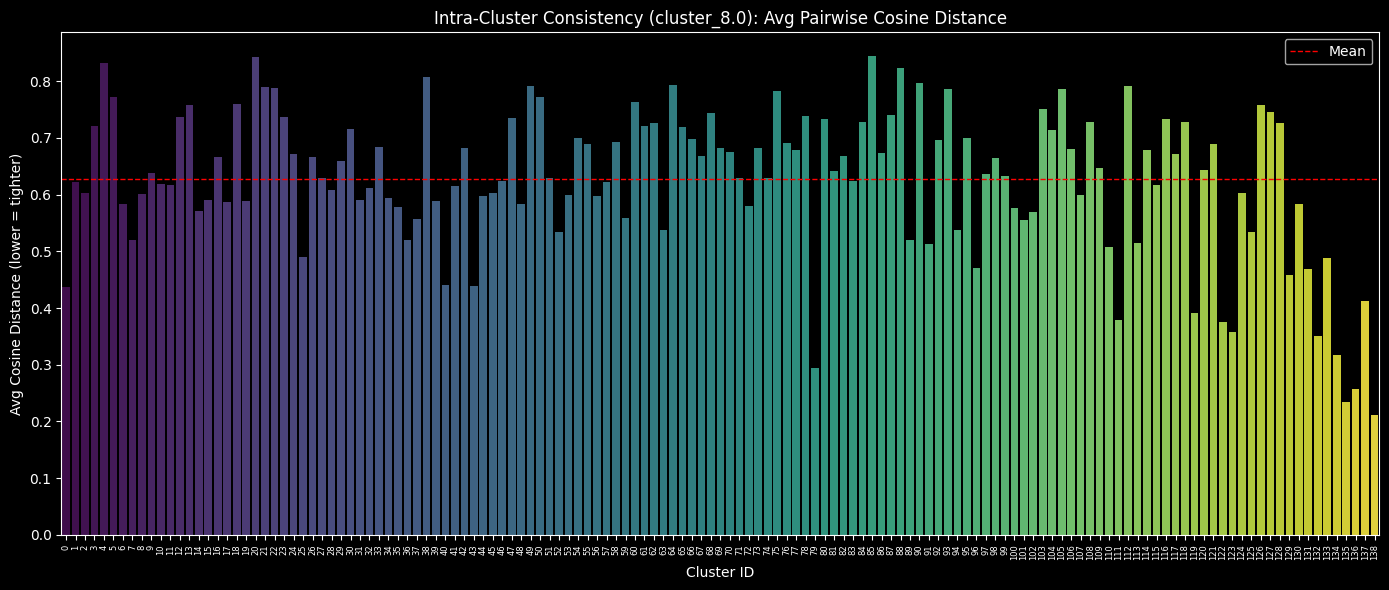

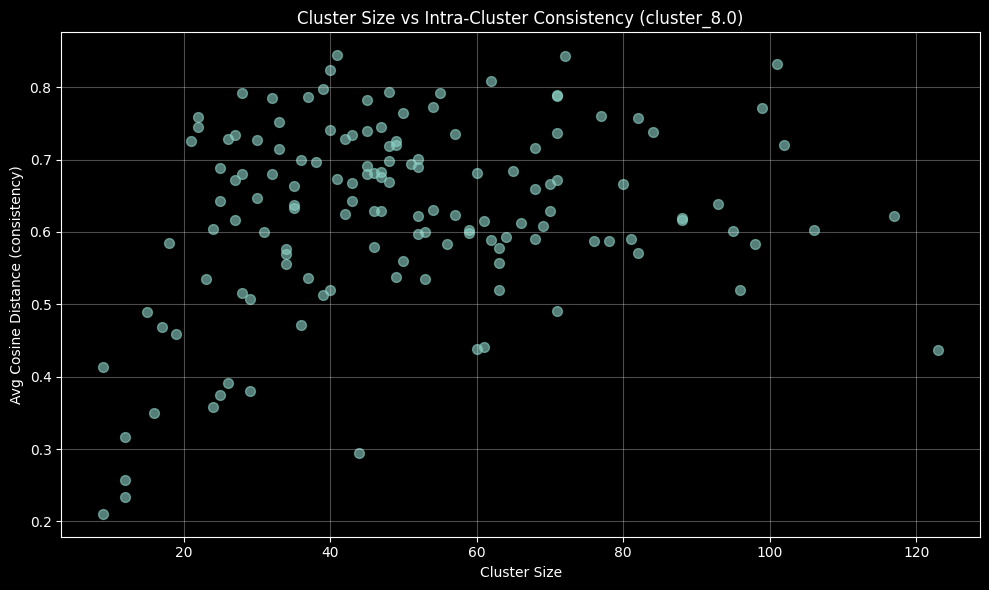

,cluster,size,avg_distance,std_distance
138,138,9,0.210463,0.106781
135,135,12,0.234357,0.160127
136,136,12,0.257812,0.194481
79,79,44,0.294551,0.114676
134,134,12,0.316579,0.122354
...,...,...,...,...
38,38,62,0.807980,0.183807
88,88,40,0.824032,0.242114
4,4,101,0.832443,0.163288
20,20,72,0.842722,0.197316


In [38]:
# Cluster size diagram (bar + cumulative)
import matplotlib.pyplot as plt
import seaborn as sns

# Resolve cluster label column robustly
cluster_cols = [c for c in topics1.columns if c.startswith('cluster_')]
if 'label_col' in globals() and label_col in topics1.columns:
    _cluster_col = label_col
elif cluster_cols:
    # choose the first with >1 unique or fallback to last
    multi = [c for c in cluster_cols if topics1[c].nunique() > 1]
    _cluster_col = multi[-1] if multi else cluster_cols[-1]
else:
    raise ValueError('No cluster_* columns found in topics DataFrame.')

counts = topics1[_cluster_col].value_counts().sort_values(ascending=False)
cluster_ids = counts.index.tolist()
cluster_sizes = counts.values
pct = cluster_sizes / cluster_sizes.sum() * 100

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=cluster_ids, y=cluster_sizes, ax=ax, color='#4C72B0')
ax.set_title(f'Cluster Size Distribution ({_cluster_col})')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Number of Topics')
#ax.bar_label(ax.containers[0], labels=[f'{v}\n({p:.1f}%)' for v, p in zip(cluster_sizes, pct)], padding=3, fontsize=8)
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

# Cumulative coverage plot
cum = pct.cumsum()
fig2, ax2 = plt.subplots(figsize=(8,4))
ax2.plot(range(len(cum)), cum, marker='o')
ax2.axhline(80, color='red', linestyle='--', linewidth=1, label='80% threshold')
ax2.set_title(f'Cumulative Percentage Coverage ({_cluster_col})')
ax2.set_xlabel('Clusters (sorted by size)')
ax2.set_ylabel('Cumulative % of Topics')
ax2.grid(alpha=0.3)
ax2.legend()
plt.tight_layout()
plt.show()


# Intra-cluster consistency: average pairwise cosine distance within each cluster
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

# Use the embedding space (dehub normalized)
emb_col_for_dist = 'embedding_dehub'
if isinstance(topics1[emb_col_for_dist].iloc[0], str):
    import ast
    topics1[emb_col_for_dist] = topics1[emb_col_for_dist].apply(
        lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
    )

X_for_dist = np.vstack(topics1[emb_col_for_dist].values).astype(np.float32)

# Resolve cluster column
cluster_cols = [c for c in topics1.columns if c.startswith('cluster_')]
if 'label_col' in globals() and label_col in topics1.columns:
    _cluster_col = label_col
elif cluster_cols:
    multi = [c for c in cluster_cols if topics1[c].nunique() > 1]
    _cluster_col = multi[-1] if multi else cluster_cols[-1]
else:
    raise ValueError('No cluster_* columns found.')

labels_for_consistency = topics1[_cluster_col].values
unique_clusters = np.unique(labels_for_consistency)
unique_clusters = unique_clusters[unique_clusters >= 0]  # exclude noise if present

consistency_data = []

for cid in unique_clusters:
    idx = np.where(labels_for_consistency == cid)[0]
    if len(idx) < 2:
        # Singleton or empty -> consistency undefined or 0
        consistency_data.append({'cluster': int(cid), 'size': len(idx), 'avg_distance': 0.0, 'std_distance': 0.0})
        continue
    
    X_cluster = X_for_dist[idx]
    # Pairwise cosine distance: 1 - cosine_similarity
    # For L2-normalized vectors, cosine_sim = dot product, so cosine_dist = 1 - dot
    # pdist with metric='cosine' computes 1 - cosine_similarity
    dists = pdist(X_cluster, metric='cosine')
    
    avg_dist = float(np.mean(dists))
    std_dist = float(np.std(dists))
    
    consistency_data.append({
        'cluster': int(cid),
        'size': len(idx),
        'avg_distance': avg_dist,
        'std_distance': std_dist
    })

df_consistency = pd.DataFrame(consistency_data).sort_values('avg_distance')

# Display summary stats
print(f"Intra-cluster consistency for {_cluster_col}:")
print(f"  Lower avg_distance => tighter (more consistent) cluster")
print(f"  Mean avg_distance across all clusters: {df_consistency['avg_distance'].mean():.4f}")
print(f"  Median avg_distance: {df_consistency['avg_distance'].median():.4f}")
print("\nTop 10 most consistent (smallest avg_distance) clusters:")
print(df_consistency.tail(10))

# Visualization: bar chart of avg_distance per cluster (sorted)
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=df_consistency, x='cluster', y='avg_distance', ax=ax, palette='viridis')
ax.set_title(f'Intra-Cluster Consistency ({_cluster_col}): Avg Pairwise Cosine Distance')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Avg Cosine Distance (lower = tighter)')
ax.axhline(df_consistency['avg_distance'].mean(), color='red', linestyle='--', linewidth=1, label='Mean')
ax.legend()
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

# Scatter: cluster size vs consistency
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.scatter(df_consistency['size'], df_consistency['avg_distance'], alpha=0.6, s=50)
ax2.set_xlabel('Cluster Size')
ax2.set_ylabel('Avg Cosine Distance (consistency)')
ax2.set_title(f'Cluster Size vs Intra-Cluster Consistency ({_cluster_col})')
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()

df_consistency

In [24]:
# Summary statistics for clustering results
print("=" * 70)
print(f"CLUSTERING SUMMARY STATISTICS FOR: {_cluster_col}")
print("=" * 70)

# Cluster size statistics
counts = topics1[_cluster_col].value_counts()
cluster_sizes = counts.values

print(f"\n📊 CLUSTER SIZE METRICS:")
print(f"  • Total number of clusters: {len(counts)}")
print(f"  • Median cluster size: {int(np.median(cluster_sizes))}")
print(f"  • Max cluster size: {int(cluster_sizes.max())}")
print(f"  • Clusters with size > 100: {int((cluster_sizes > 100).sum())}")
print(f"  • Clusters with size < 3: {int((cluster_sizes < 3).sum())}")

# Consistency statistics (from df_consistency DataFrame)
mean_avg_dist = df_consistency['avg_distance'].mean()
median_avg_dist = df_consistency['avg_distance'].median()
n_high_distance = (df_consistency['avg_distance'] > 0.8).sum()

print(f"\n🎯 INTRA-CLUSTER CONSISTENCY METRICS:")
print(f"  • Mean avg_distance across all clusters: {mean_avg_dist:.4f}")
print(f"  • Median avg_distance: {median_avg_dist:.4f}")
print(f"  • Clusters with avg_distance > 0.8 (loose): {int(n_high_distance)}")
print(f"  • Clusters with avg_distance ≤ 0.8 (tight): {int(len(df_consistency) - n_high_distance)}")

print("\n" + "=" * 70)
print(f"Note: Lower avg_distance indicates tighter (more consistent) clusters.")
print(f"      Cosine distance ranges from 0 (identical) to 2 (opposite).")
print("=" * 70)

CLUSTERING SUMMARY STATISTICS FOR: cluster_2.0

📊 CLUSTER SIZE METRICS:
  • Total number of clusters: 144
  • Median cluster size: 39
  • Max cluster size: 192
  • Clusters with size > 100: 14
  • Clusters with size < 3: 15

🎯 INTRA-CLUSTER CONSISTENCY METRICS:
  • Mean avg_distance across all clusters: 0.5834
  • Median avg_distance: 0.6180
  • Clusters with avg_distance > 0.8 (loose): 18
  • Clusters with avg_distance ≤ 0.8 (tight): 126

Note: Lower avg_distance indicates tighter (more consistent) clusters.
      Cosine distance ranges from 0 (identical) to 2 (opposite).


### Experiments

In [25]:
# Comprehensive Graph + Leiden clustering experiments
# Grid search over k, resolutions, and weighting methods
import time
from scipy.spatial.distance import pdist
import pandas as pd
import numpy as np

# Experimental parameters
k_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]
resolutions = [1.0, 1.3, 1.6, 2.0, 2.2, 2.5, 2.7, 3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
weighting_methods = ['jaccard', 'selftuned']

# Prepare embedding matrix (using the same as before)
emb_col = 'embedding_norm'
if isinstance(topics1[emb_col].iloc[0], str):
    import ast
    topics1[emb_col] = topics1[emb_col].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)

X = np.vstack(topics1[emb_col].values).astype(np.float32)

# Prepare dehub embeddings for consistency calculation
emb_col_for_dist = 'embedding_dehub'
if isinstance(topics1[emb_col_for_dist].iloc[0], str):
    import ast
    topics1[emb_col_for_dist] = topics1[emb_col_for_dist].apply(
        lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
    )
X_for_dist = np.vstack(topics1[emb_col_for_dist].values).astype(np.float32)

results = []
total_experiments = len(k_values) * len(resolutions) * len(weighting_methods)
experiment_counter = 0

print(f"Starting {total_experiments} experiments...")
print(f"k values: {k_values}")
print(f"resolutions: {resolutions}")
print(f"weighting methods: {weighting_methods}")
print("=" * 80)

start_time = time.time()

for weighting in weighting_methods:
    for k in k_values:
        # Adjust k if necessary
        k_adj = min(k, X.shape[0]-1) if X.shape[0] > 1 else 1
        
        # Build graph
        t0 = time.time()
        g = build_mutual_knn_graph(X, k=k_adj, weighting=weighting, ensure_min_degree=True)
        graph_time = time.time() - t0
        
        # Run Leiden across all resolutions
        t0 = time.time()
        parts = run_leiden_over_resolutions(g, resolutions=tuple(resolutions), seed=42)
        leiden_time = time.time() - t0
        
        # For each resolution, compute statistics
        for res in resolutions:
            experiment_counter += 1
            labels = parts[res]
            
            # Cluster size statistics
            counts = pd.Series(labels).value_counts()
            cluster_sizes = counts.values
            n_clusters = len(counts)
            median_size = int(np.median(cluster_sizes))
            max_size = int(cluster_sizes.max())
            n_large = int((cluster_sizes > 100).sum())
            n_small = int((cluster_sizes < 3).sum())
            
            # Consistency calculation (average pairwise cosine distance per cluster)
            unique_clusters = np.unique(labels)
            unique_clusters = unique_clusters[unique_clusters >= 0]
            
            consistency_data = []
            for cid in unique_clusters:
                idx = np.where(labels == cid)[0]
                if len(idx) < 2:
                    consistency_data.append(0.0)
                    continue
                
                X_cluster = X_for_dist[idx]
                dists = pdist(X_cluster, metric='cosine')
                avg_dist = float(np.mean(dists))
                consistency_data.append(avg_dist)
            
            if len(consistency_data) > 0:
                mean_avg_dist = np.mean(consistency_data)
                median_avg_dist = np.median(consistency_data)
                n_loose = int(np.sum(np.array(consistency_data) > 0.8))
                n_tight = int(np.sum(np.array(consistency_data) <= 0.8))
            else:
                mean_avg_dist = 0.0
                median_avg_dist = 0.0
                n_loose = 0
                n_tight = 0
            
            # Store results
            model_name = f"k{k}_r{res}_{weighting}"
            results.append({
                'model_name': model_name,
                'k': k,
                'resolution': res,
                'weighting': weighting,
                'n_clusters': n_clusters,
                'median_size': median_size,
                'max_size': max_size,
                'clusters_gt_100': n_large,
                'clusters_lt_3': n_small,
                'mean_avg_distance': round(mean_avg_dist, 4),
                'median_avg_distance': round(median_avg_dist, 4),
                'clusters_loose_gt_0.8': n_loose,
                'clusters_tight_le_0.8': n_tight,
            })
            
            if experiment_counter % 10 == 0:
                elapsed = time.time() - start_time
                avg_time = elapsed / experiment_counter
                remaining = (total_experiments - experiment_counter) * avg_time
                print(f"Progress: {experiment_counter}/{total_experiments} ({100*experiment_counter/total_experiments:.1f}%) | "
                      f"Elapsed: {elapsed:.1f}s | ETA: {remaining:.1f}s")

total_time = time.time() - start_time
print("=" * 80)
print(f"Completed {total_experiments} experiments in {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"Average time per experiment: {total_time/total_experiments:.2f}s")

# Create results DataFrame
df_results = pd.DataFrame(results)

print("\n" + "=" * 80)
print("EXPERIMENTAL RESULTS SUMMARY")
print("=" * 80)
print(f"Total experiments: {len(df_results)}")
print(f"\nColumns: {list(df_results.columns)}")
print("\nFirst 10 rows:")
print(df_results.head(10))

df_results

Starting 288 experiments...
k values: [10, 15, 20, 25, 30, 35, 40, 45, 50]
resolutions: [1.0, 1.3, 1.6, 2.0, 2.2, 2.5, 2.7, 3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
weighting methods: ['jaccard', 'selftuned']
Progress: 10/288 (3.5%) | Elapsed: 3.3s | ETA: 92.6s
Progress: 20/288 (6.9%) | Elapsed: 7.2s | ETA: 96.6s
Progress: 30/288 (10.4%) | Elapsed: 7.4s | ETA: 63.6s
Progress: 40/288 (13.9%) | Elapsed: 12.6s | ETA: 78.2s
Progress: 50/288 (17.4%) | Elapsed: 19.0s | ETA: 90.2s
Progress: 60/288 (20.8%) | Elapsed: 19.2s | ETA: 72.8s
Progress: 70/288 (24.3%) | Elapsed: 25.0s | ETA: 78.0s
Progress: 80/288 (27.8%) | Elapsed: 25.3s | ETA: 65.7s
Progress: 90/288 (31.2%) | Elapsed: 32.1s | ETA: 70.7s
Progress: 100/288 (34.7%) | Elapsed: 39.0s | ETA: 73.3s
Progress: 110/288 (38.2%) | Elapsed: 39.2s | ETA: 63.5s
Progress: 120/288 (41.7%) | Elapsed: 49.5s | ETA: 69.3s
Progress: 130/288 (45.1%) | Elapsed: 57.1s | ETA: 69.3s
Progress: 140/288 (48.6%) | Elapsed: 57.4s | ETA: 60.7s
Progress: 150/28

,model_name,k,resolution,weighting,n_clusters,median_size,max_size,clusters_gt_100,clusters_lt_3,mean_avg_distance,median_avg_distance,clusters_loose_gt_0.8,clusters_tight_le_0.8
0,k10_r1.0_jaccard,10,1.0,jaccard,215,13,192,19,50,0.5118,0.5059,25,190
1,k10_r1.3_jaccard,10,1.3,jaccard,227,14,150,15,50,0.5148,0.5105,26,201
2,k10_r1.6_jaccard,10,1.6,jaccard,241,16,145,8,50,0.5179,0.5192,26,215
3,k10_r2.0_jaccard,10,2.0,jaccard,254,16,133,6,50,0.5163,0.5248,22,232
4,k10_r2.2_jaccard,10,2.2,jaccard,260,16,133,4,50,0.5179,0.5327,20,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,k50_r6.0_selftuned,50,6.0,selftuned,112,59,133,12,0,0.6542,0.6691,6,106
284,k50_r7.0_selftuned,50,7.0,selftuned,126,50,131,7,0,0.6356,0.6606,7,119
285,k50_r8.0_selftuned,50,8.0,selftuned,139,47,123,5,0,0.6271,0.6371,5,134
286,k50_r9.0_selftuned,50,9.0,selftuned,148,45,121,3,0,0.6217,0.6317,7,141


### Run and save selected model

Graph + Leiden clustering with the selected parameters:
k = 50;
resolution = 8.0;
weight = 'selftuned'.
Reasons:
A relatively small number of clusters – 139
There are no giant clusters, only 5 larger (with 100 members)
There are 5 loose clusters (cosine distance greater than 0.8).
The average cosine distance is larger, but this is due to the clumping of small clusters.
There are no small clusters.

In [68]:
# Run Graph + Leiden clustering with selected parameters
# k=50, resolution=8.0, weighting='selftuned'
import time
from scipy.spatial.distance import pdist
import pandas as pd
import numpy as np

print("=" * 80)
print("RUNNING CLUSTERING WITH SELECTED PARAMETERS")
print("=" * 80)
print(f"k = 50")
print(f"resolution = 8.0")
print(f"weighting = 'selftuned'")
print(f"ensure_min_degree = True")
print("=" * 80)

# Prepare embedding matrix
emb_col = 'embedding_norm'
if isinstance(topics1[emb_col].iloc[0], str):
    import ast
    topics1[emb_col] = topics1[emb_col].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)

X = np.vstack(topics1[emb_col].values).astype(np.float32)

# Prepare dehub embeddings for consistency calculation
emb_col_for_dist = 'embedding_dehub'
if isinstance(topics1[emb_col_for_dist].iloc[0], str):
    import ast
    topics1[emb_col_for_dist] = topics1[emb_col_for_dist].apply(
        lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
    )
X_for_dist = np.vstack(topics1[emb_col_for_dist].values).astype(np.float32)

# Step 1: Build graph
print("\nStep 1: Building mutual kNN graph...")
t0 = time.time()
k = 50
g = build_mutual_knn_graph(X, k=k, weighting='selftuned', ensure_min_degree=True)
graph_time = time.time() - t0
print(f"  Graph built: {g.vcount()} nodes, {g.ecount()} edges")
print(f"  Time: {graph_time:.2f}s")

# Step 2: Run Leiden clustering
print("\nStep 2: Running Leiden clustering...")
t0 = time.time()
resolution = 8.0
parts = run_leiden_over_resolutions(g, resolutions=(resolution,), seed=42)
leiden_time = time.time() - t0
labels = parts[resolution]
print(f"  Clustering completed")
print(f"  Time: {leiden_time:.2f}s")

# Step 3: Add cluster membership to topics1
cluster_col_name = 'cluster_k50_r8.0_selftuned'
topics1[cluster_col_name] = labels
print(f"\nStep 3: Added column '{cluster_col_name}' to topics1")

# Step 4: Compute cluster statistics and consistency
print("\nStep 4: Computing cluster statistics and consistency metrics...")

# Basic cluster statistics
counts = pd.Series(labels).value_counts().sort_index()
cluster_sizes = counts.values
n_clusters = len(counts)
median_size = int(np.median(cluster_sizes))
max_size = int(cluster_sizes.max())
n_large = int((cluster_sizes > 100).sum())
n_small = int((cluster_sizes < 3).sum())

# Detailed cluster composition with consistency metrics
from scipy.spatial.distance import cdist

cluster_composition = []
unique_clusters = np.unique(labels)

for cid in unique_clusters:
    idx = np.where(labels == cid)[0]
    cluster_size = len(idx)
    
    # Get cluster members (terms)
    members = topics1.iloc[idx]['term'].tolist()
    
    # Extract cluster embeddings
    X_cluster = X_for_dist[idx]
    
    # Calculate intra-cluster consistency (pairwise distances)
    if cluster_size < 2:
        avg_dist = 0.0
        std_dist = 0.0
        min_dist = 0.0
        max_dist = 0.0
        avg_dist_to_center = 0.0
    else:
        dists = pdist(X_cluster, metric='cosine')
        avg_dist = float(np.mean(dists))
        std_dist = float(np.std(dists))
        min_dist = float(np.min(dists))
        max_dist = float(np.max(dists))
        
        # Calculate average distance to cluster center (centroid)
        centroid = X_cluster.mean(axis=0, keepdims=True)
        dists_to_center = cdist(centroid, X_cluster, metric='cosine')[0]
        avg_dist_to_center = float(np.mean(dists_to_center))
    
    cluster_composition.append({
        'cluster_id': int(cid),
        'cluster_size': cluster_size,
        'avg_distance': round(avg_dist, 4),
        'std_distance': round(std_dist, 4),
        'min_distance': round(min_dist, 4),
        'max_distance': round(max_dist, 4),
        'avg_dist_to_center': round(avg_dist_to_center, 4),
        'members': members
    })

df_cluster_composition = pd.DataFrame(cluster_composition).sort_values('cluster_size', ascending=False)

# Overall consistency statistics
consistency_values = [row['avg_distance'] for row in cluster_composition if row['cluster_size'] >= 2]
if len(consistency_values) > 0:
    mean_avg_dist = np.mean(consistency_values)
    median_avg_dist = np.median(consistency_values)
    n_loose = int(np.sum(np.array(consistency_values) > 0.8))
    n_tight = int(np.sum(np.array(consistency_values) <= 0.8))
else:
    mean_avg_dist = 0.0
    median_avg_dist = 0.0
    n_loose = 0
    n_tight = 0

# Step 5: Display summary statistics
print("\n" + "=" * 80)
print("CLUSTERING SUMMARY STATISTICS")
print("=" * 80)

print(f"\n📊 CLUSTER SIZE METRICS:")
print(f"  • Total number of clusters: {n_clusters}")
print(f"  • Median cluster size: {median_size}")
print(f"  • Max cluster size: {max_size}")
print(f"  • Clusters with size > 100: {n_large}")
print(f"  • Clusters with size < 3: {n_small}")

print(f"\n🎯 INTRA-CLUSTER CONSISTENCY METRICS:")
print(f"  • Mean avg_distance across all clusters: {mean_avg_dist:.4f}")
print(f"  • Median avg_distance: {median_avg_dist:.4f}")
print(f"  • Clusters with avg_distance > 0.8 (loose): {n_loose}")
print(f"  • Clusters with avg_distance ≤ 0.8 (tight): {n_tight}")

print("\n" + "=" * 80)
print(f"Note: Lower avg_distance indicates tighter (more consistent) clusters.")
print(f"      Cosine distance ranges from 0 (identical) to 2 (opposite).")
print("=" * 80)

print(f"\n✅ Clustering completed successfully!")
print(f"   Total time: {graph_time + leiden_time:.2f}s")
print(f"\n📋 Output DataFrames:")
print(f"   1. topics1 - updated with column '{cluster_col_name}'")
print(f"   2. df_cluster_composition - cluster details with {len(df_cluster_composition)} rows")
print("\n" + "=" * 80)

# Display top 10 clusters by size
print("\nTop 10 Largest Clusters:")
print(df_cluster_composition[['cluster_id', 'cluster_size', 'avg_distance', 'avg_dist_to_center']].head(10))

print("\nTop 10 Most Consistent Clusters (lowest avg_distance):")
consistent_clusters = df_cluster_composition[df_cluster_composition['cluster_size'] >= 2].sort_values('avg_distance')
print(consistent_clusters[['cluster_id', 'cluster_size', 'avg_distance', 'avg_dist_to_center']].head(10))

# Return the cluster composition dataframe
df_cluster_composition

RUNNING CLUSTERING WITH SELECTED PARAMETERS
k = 50
resolution = 8.0
weighting = 'selftuned'
ensure_min_degree = True

Step 1: Building mutual kNN graph...
  Graph built: 6971 nodes, 92766 edges
  Time: 2.00s

Step 2: Running Leiden clustering...
  Graph built: 6971 nodes, 92766 edges
  Time: 2.00s

Step 2: Running Leiden clustering...
  Clustering completed
  Time: 0.43s

Step 3: Added column 'cluster_k50_r8.0_selftuned' to topics1

Step 4: Computing cluster statistics and consistency metrics...

CLUSTERING SUMMARY STATISTICS

📊 CLUSTER SIZE METRICS:
  • Total number of clusters: 139
  • Median cluster size: 47
  • Max cluster size: 123
  • Clusters with size > 100: 5
  • Clusters with size < 3: 0

🎯 INTRA-CLUSTER CONSISTENCY METRICS:
  • Mean avg_distance across all clusters: 0.6271
  • Median avg_distance: 0.6371
  • Clusters with avg_distance > 0.8 (loose): 5
  • Clusters with avg_distance ≤ 0.8 (tight): 134

Note: Lower avg_distance indicates tighter (more consistent) clusters.
   

,cluster_id,cluster_size,avg_distance,std_distance,min_distance,max_distance,avg_dist_to_center,members
0,0,123,0.4369,0.1003,0.0074,0.7597,0.2472,"[audio llms, code generation (llms), code gene..."
1,1,117,0.6215,0.1497,0.0369,1.1895,0.3805,"[alexa, alexa integration, alexa skill develop..."
2,2,106,0.6026,0.1492,0.0156,1.1144,0.3651,"[a2a protocol, action, action agent, agent, ag..."
3,3,102,0.7208,0.1797,0.0257,1.1733,0.4649,"[agi safety, ai accountability, ai act, ai ali..."
4,4,101,0.8324,0.1633,0.1028,1.2509,0.5807,"[accessibility, ai adoption, ai algorithms, ai..."
...,...,...,...,...,...,...,...,...
134,134,12,0.3166,0.1224,0.0301,0.5667,0.1575,"[ai debugging, automated debugging, code debug..."
135,135,12,0.2344,0.1601,0.0384,0.6244,0.1139,"[design-to-code, low-code ai, low-code develop..."
136,136,12,0.2578,0.1945,0.0216,0.7389,0.1261,"[mcp (model context protocol), mcp (model cont..."
137,137,9,0.4127,0.1361,0.0246,0.6465,0.2043,"[conditional gan, cyclegan, dcgan, gail, gans ..."


In [69]:
topics1

,id,term,definition,count,similarity_to_AI,consensus_score,embedding_norm,embedding_dehub,cluster_k50_r8.0_selftuned
0,6.0,1-bit inference,1-bit inference refers to the process of runni...,2.0,0.280766,4,"[0.013369597494602203, -0.013582168146967888, ...","[-0.10377315, 0.024112597, -0.37237495, -0.070...",7
1,7.0,1-bit llm,A 1-bit large language model (LLM) is a highly...,5.0,0.220254,4,"[0.017574984580278397, -0.004011554177850485, ...","[-0.041667353, -0.1235163, 0.33915088, -0.0217...",7
2,9.0,1-bit quantization,1-bit quantization is an extreme model compres...,6.0,0.187808,3,"[-0.015226091258227825, 0.0012089560041204095,...","[-0.052673534, 0.017871799, -0.36147624, -0.01...",7
3,14.0,2-bit quantization,2-bit quantization is a process that reduces t...,4.0,0.190536,4,"[-0.006645898800343275, 0.006167215760797262, ...","[-0.05830743, 0.014523482, -0.35151455, 0.0150...",7
4,17.0,2d animation,"""2D animation"" refers to the use of artificial...",3.0,0.370161,5,"[0.008917991071939468, -0.002153154695406556, ...","[0.31390756, -0.02592274, -0.26441434, 0.10848...",28
...,...,...,...,...,...,...,...,...,...
6966,19003.0,zero-shot voice cloning,Zero-shot voice cloning is the task of synthes...,3.0,0.212219,4,"[-0.007965235970914364, -0.027662577107548714,...","[0.38904208, 0.0016928717, -0.1268675, -0.0348...",90
6967,19007.0,zero-trust security,Zero-trust security for AI/ML is an architectu...,4.0,0.419530,5,"[-0.01758248545229435, 0.059987302869558334, 0...","[-0.24598806, -0.0046496205, 0.06976296, 0.038...",90
6968,19010.0,zero/zero++,"""Zero"" (zero-shot) refers to applying or evalu...",2.0,0.243124,4,"[-0.0007028839900158346, 0.011448170058429241,...","[0.057271093, 0.020468256, -0.22577171, -0.227...",90
6969,19012.0,zerogpu,"Zerogpu (often stylized ""zerogpu"") refers to C...",2.0,0.299549,4,"[0.004047493916004896, 0.05906970053911209, 0....","[-0.20782912, -0.43594316, -0.291142, -0.16293...",90


### Re-cluster too large and loose clusters
Recursively re-clustering Clusters

In [81]:
# Recursive re-clustering of large, loose clusters
# Using Graph + Leiden at higher resolution to split into smaller, tighter subclusters
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress sklearn warnings about regression-like classification (occurs with many small clusters)
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.metrics')
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

topics2 = topics1.copy()

print("=" * 80)
print("RECURSIVE RE-CLUSTERING OF LARGE/LOOSE CLUSTERS")
print("=" * 80)

# Target clusters to re-cluster
target_clusters = [3, 4, 5, 20, 85]
print(f"\nTarget clusters for re-clustering: {target_clusters}")

# Parameters for re-clustering (higher resolution than original)
reclustering_params = {
    'k': 40,  # Slightly lower k for finer granularity
    'resolutions': [0.5, 0.6, 0.7, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0],  # Higher resolutions to create more clusters
    'weighting': 'selftuned',
    'seed': 42
}

print(f"\nRe-clustering parameters:")
print(f"  k = {reclustering_params['k']}")
print(f"  resolutions = {reclustering_params['resolutions']}")
print(f"  weighting = '{reclustering_params['weighting']}'")

# Use existing data
cluster_col = 'cluster_k50_r8.0_selftuned'
emb_col_for_dist = 'embedding_dehub'

# Prepare full embedding matrix
if isinstance(topics2[emb_col_for_dist].iloc[0], str):
    import ast
    topics2[emb_col_for_dist] = topics2[emb_col_for_dist].apply(
        lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
    )
X_full = np.vstack(topics2[emb_col_for_dist].values).astype(np.float32)

# Store subclustering results
subcluster_results = {}
new_cluster_col = f'{cluster_col}_refined'
topics2[new_cluster_col] = topics2[cluster_col].copy()  # Start with original labels

# Next available cluster ID (for newly created subclusters)
max_cluster_id = topics2[cluster_col].max()
next_cluster_id = max_cluster_id + 1

print("\n" + "=" * 80)

for target_cid in target_clusters:
    print(f"\n🔄 Processing Cluster {target_cid}")
    print("-" * 80)
    
    # Get indices of members in this cluster
    idx = np.where(topics2[cluster_col].values == target_cid)[0]
    cluster_size = len(idx)
    
    # Get cluster info from df_cluster_composition
    cluster_info = df_cluster_composition[df_cluster_composition['cluster_id'] == target_cid].iloc[0]
    
    print(f"Original cluster size: {cluster_size}")
    print(f"Avg pairwise distance: {cluster_info['avg_distance']:.4f}")
    print(f"Avg distance to center: {cluster_info['avg_dist_to_center']:.4f}")
    
    
    # Extract submatrix for this cluster
    X_sub = X_full[idx]
    
    # Build graph for subcluster
    t0 = time.time()
    k_adj = min(reclustering_params['k'], X_sub.shape[0]-1) if X_sub.shape[0] > 1 else 1
    g_sub = build_mutual_knn_graph(X_sub, k=k_adj, weighting=reclustering_params['weighting'], ensure_min_degree=True)
    graph_time = time.time() - t0
    
    print(f"\n  Graph built: {g_sub.vcount()} nodes, {g_sub.ecount()} edges (k={k_adj}, {graph_time:.2f}s)")
    
    # Run Leiden across multiple resolutions
    t0 = time.time()
    parts_sub = run_leiden_over_resolutions(g_sub, resolutions=tuple(reclustering_params['resolutions']), seed=reclustering_params['seed'])
    leiden_time = time.time() - t0
    
    print(f"  Leiden clustering completed ({leiden_time:.2f}s)")
    
    # Evaluate resolutions and select best
    diag_sub = suggest_resolution(parts_sub, max_singletons_ratio=0.05, min_median_size=5)
    suggested_res = diag_sub['suggested']
    
    print(f"\n  Resolution analysis:")
    for res, sm in diag_sub['summaries'].items():
        sing_ratio = sm['n_singletons'] / len(parts_sub[res])
        print(f"    r={res}: n_clusters={sm['n_clusters']}, median_size={sm['median_size']}, max_size={sm['max_size']}, singletons={sm['n_singletons']} ({sing_ratio:.1%})")
    
    print(f"\n  ✓ Selected resolution: {suggested_res}")
    
    # Get subclusters for selected resolution
    sublabels = parts_sub[suggested_res]
    n_subclusters = len(np.unique(sublabels))
    
    # Compute consistency for subclusters
    subcluster_stats = []
    for sub_cid in np.unique(sublabels):
        sub_idx_local = np.where(sublabels == sub_cid)[0]
        sub_idx_global = idx[sub_idx_local]
        sub_size = len(sub_idx_local)
        
        if sub_size < 2:
            avg_dist_sub = 0.0
        else:
            X_sub_cluster = X_sub[sub_idx_local]
            dists_sub = pdist(X_sub_cluster, metric='cosine')
            avg_dist_sub = float(np.mean(dists_sub))
        
        subcluster_stats.append({
            'subcluster_id': sub_cid,
            'size': sub_size,
            'avg_distance': avg_dist_sub
        })
    
    df_sub_stats = pd.DataFrame(subcluster_stats).sort_values('size', ascending=False)
    
    print(f"\n  📊 Subclustering summary:")
    print(f"    • Number of subclusters: {n_subclusters}")
    print(f"    • Mean subcluster size: {df_sub_stats['size'].mean():.1f}")
    print(f"    • Median subcluster size: {df_sub_stats['size'].median():.1f}")
    print(f"    • Mean avg_distance: {df_sub_stats[df_sub_stats['size']>=2]['avg_distance'].mean():.4f}")
    
    print(f"\n  Top 5 largest subclusters:")
    for _, row in df_sub_stats.head(5).iterrows():
        print(f"    Subcluster {row['subcluster_id']}: size={row['size']}, avg_dist={row['avg_distance']:.4f}")
    
    # Map sublabels to new global cluster IDs
    subcluster_mapping = {}
    for sub_cid in np.unique(sublabels):
        subcluster_mapping[sub_cid] = next_cluster_id
        next_cluster_id += 1
    
    # Update topics2 with new cluster assignments
    for i, sub_cid in enumerate(sublabels):
        global_idx = idx[i]
        new_cid = subcluster_mapping[sub_cid]
        topics2.at[global_idx, new_cluster_col] = new_cid
    
    # Store results
    subcluster_results[target_cid] = {
        'original_size': cluster_size,
        'n_subclusters': n_subclusters,
        'resolution': suggested_res,
        'mapping': subcluster_mapping,
        'stats': df_sub_stats,
        'original_avg_distance': cluster_info['avg_distance'],
        'new_mean_avg_distance': df_sub_stats[df_sub_stats['size']>=2]['avg_distance'].mean() if len(df_sub_stats[df_sub_stats['size']>=2]) > 0 else 0.0
    }
    
    print(f"\n  ✅ Cluster {target_cid} split into {n_subclusters} subclusters (IDs: {list(subcluster_mapping.values())})")
    print("-" * 80)

print("\n" + "=" * 80)
print("RECURSIVE RE-CLUSTERING COMPLETED")
print("=" * 80)

# Summary statistics
print(f"\n📊 OVERALL SUMMARY:")
total_original_size = sum([r['original_size'] for r in subcluster_results.values()])
total_new_clusters = sum([r['n_subclusters'] for r in subcluster_results.values()])
print(f"  • Original clusters processed: {len(target_clusters)}")
print(f"  • Total members re-clustered: {total_original_size}")
print(f"  • New subclusters created: {total_new_clusters}")
print(f"  • New cluster ID range: {max_cluster_id + 1} to {next_cluster_id - 1}")

print(f"\n  Consistency improvements:")
for target_cid, result in subcluster_results.items():
    improvement = result['original_avg_distance'] - result['new_mean_avg_distance']
    print(f"    Cluster {target_cid}: {result['original_avg_distance']:.4f} → {result['new_mean_avg_distance']:.4f} (Δ={improvement:.4f})")

# Update cluster count
n_clusters_original = topics2[cluster_col].nunique()
n_clusters_refined = topics2[new_cluster_col].nunique()
print(f"\n  Total clusters: {n_clusters_original} → {n_clusters_refined} (net gain: +{n_clusters_refined - n_clusters_original})")

print(f"\n✅ New cluster column '{new_cluster_col}' added to topics2")
print("=" * 80)

# Display updated cluster distribution
print(f"\n\nTop 20 clusters by size ({new_cluster_col}):")
counts_refined = topics2[new_cluster_col].value_counts().head(20)
print(counts_refined)

# Step 5: Calculate new df_cluster_composition based on refined clustering
print("\n" + "=" * 80)
print("CALCULATING NEW CLUSTER COMPOSITION FOR REFINED CLUSTERING")
print("=" * 80)

from scipy.spatial.distance import cdist

labels_refined = topics2[new_cluster_col].values
unique_clusters_refined = np.unique(labels_refined)

cluster_composition_refined = []

for cid in unique_clusters_refined:
    idx = np.where(labels_refined == cid)[0]
    cluster_size = len(idx)
    
    # Get cluster members (terms)
    members = topics2.iloc[idx]['term'].tolist()
    
    # Extract cluster embeddings
    X_cluster = X_full[idx]
    
    # Calculate intra-cluster consistency (pairwise distances) and distance to center
    if cluster_size < 2:
        avg_dist = 0.0
        std_dist = 0.0
        min_dist = 0.0
        max_dist = 0.0
        avg_dist_to_center = 0.0
        centroid_term = members[0] if members else None
        members_sorted = members
        closest_5 = members[:5]
        members_cleaned = members  # Singleton cluster: include the member
        cleaned_size = len(members)
    else:
        dists = pdist(X_cluster, metric='cosine')
        avg_dist = float(np.mean(dists))
        std_dist = float(np.std(dists))
        min_dist = float(np.min(dists))
        max_dist = float(np.max(dists))
        
        # Calculate distances to cluster center (centroid)
        centroid = X_cluster.mean(axis=0, keepdims=True)
        dists_to_center = cdist(centroid, X_cluster, metric='cosine')[0]
        avg_dist_to_center = float(np.mean(dists_to_center))
        
        # Find centroid (medoid): actual member closest to centroid
        medoid_idx = np.argmin(dists_to_center)
        centroid_term = members[medoid_idx]
        
        # Sort members by distance to centroid (closest first)
        sorted_indices = np.argsort(dists_to_center)
        members_sorted = [members[i] for i in sorted_indices]
        
        # Get 5 closest members
        closest_5 = members_sorted[:5]
        
        # Filter members: keep only those with distance <= 0.8 to cluster center
        members_cleaned = [members[i] for i in range(len(members)) if dists_to_center[i] <= 0.8]
        cleaned_size = len(members_cleaned)
    
    cluster_composition_refined.append({
        'cluster_id': int(cid),
        'cluster_size': cluster_size,
        'avg_distance': round(avg_dist, 4),
        'std_distance': round(std_dist, 4),
        'min_distance': round(min_dist, 4),
        'max_distance': round(max_dist, 4),
        'avg_dist_to_center': round(avg_dist_to_center, 4),
        'centroid': centroid_term,
        'closest_5_members': closest_5,
        'members': members_sorted,
        'members_cleaned': members_cleaned,
        'cleaned_size': cleaned_size
    })

df_cluster_composition_refined = pd.DataFrame(cluster_composition_refined).sort_values('cluster_size', ascending=False)

# Overall consistency statistics for refined clustering
consistency_values_refined = [row['avg_distance'] for row in cluster_composition_refined if row['cluster_size'] >= 2]
if len(consistency_values_refined) > 0:
    mean_avg_dist_refined = np.mean(consistency_values_refined)
    median_avg_dist_refined = np.median(consistency_values_refined)
    n_loose_refined = int(np.sum(np.array(consistency_values_refined) > 0.8))
    n_tight_refined = int(np.sum(np.array(consistency_values_refined) <= 0.8))
else:
    mean_avg_dist_refined = 0.0
    median_avg_dist_refined = 0.0
    n_loose_refined = 0
    n_tight_refined = 0

print(f"\n📊 REFINED CLUSTERING STATISTICS:")
print(f"  • Total number of clusters: {len(unique_clusters_refined)}")
print(f"  • Median cluster size: {int(np.median([r['cluster_size'] for r in cluster_composition_refined]))}")
print(f"  • Max cluster size: {max([r['cluster_size'] for r in cluster_composition_refined])}")
print(f"  • Mean avg_distance: {mean_avg_dist_refined:.4f}")
print(f"  • Median avg_distance: {median_avg_dist_refined:.4f}")
print(f"  • Clusters with avg_distance > 0.8 (loose): {n_loose_refined}")
print(f"  • Clusters with avg_distance ≤ 0.8 (tight): {n_tight_refined}")

# Cleaned members statistics
total_original_members = sum([r['cluster_size'] for r in cluster_composition_refined])
total_cleaned_members = sum([r['cleaned_size'] for r in cluster_composition_refined])
retention_rate = total_cleaned_members / total_original_members if total_original_members > 0 else 0

print(f"\n📋 CLEANED MEMBERS STATISTICS (distance ≤ 0.8):")
print(f"  • Original total members: {total_original_members}")
print(f"  • Cleaned total members: {total_cleaned_members}")
print(f"  • Retention rate: {retention_rate:.1%}")
print(f"  • Members removed (outliers): {total_original_members - total_cleaned_members}")

print("\n" + "=" * 80)
print(f"✅ df_cluster_composition_refined created with {len(df_cluster_composition_refined)} rows")
print(f"   Columns: cluster_id, cluster_size, avg_distance, std_distance, min_distance,")
print(f"            max_distance, avg_dist_to_center, centroid, closest_5_members,")
print(f"            members, members_cleaned, cleaned_size")
print("=" * 80)

print("\n\nTop 10 Largest Clusters (Refined):")
display_cols = ['cluster_id', 'cluster_size', 'cleaned_size', 'avg_distance', 'avg_dist_to_center', 'centroid']
print(df_cluster_composition_refined[display_cols].head(10))

print("\n\nTop 10 Most Consistent Clusters (Refined, lowest avg_distance):")
consistent_clusters_refined = df_cluster_composition_refined[df_cluster_composition_refined['cluster_size'] >= 2].sort_values('avg_distance')
print(consistent_clusters_refined[display_cols].head(10))

print("\n\nExample: Closest 5 members for largest refined cluster:")
largest_cluster_refined = df_cluster_composition_refined.iloc[0]
print(f"Cluster {largest_cluster_refined['cluster_id']} (size: {largest_cluster_refined['cluster_size']})")
print(f"Centroid (medoid): {largest_cluster_refined['centroid']}")
print(f"Closest 5 members: {largest_cluster_refined['closest_5_members']}")

# Step 6: Enhance topics2 with refined clustering results
print("\n" + "=" * 80)
print("ENHANCING topics2 WITH REFINED CLUSTERING")
print("=" * 80)

# Calculate distance to center for each topic in the refined clustering
print("\nCalculating distances to cluster centers...")

labels_refined = topics2[new_cluster_col].values
distance_to_center_refined = np.zeros(len(topics2))

# Compute centroids and distances for each cluster
for cid in unique_clusters_refined:
    idx = np.where(labels_refined == cid)[0]
    
    if len(idx) == 1:
        # Singleton cluster: distance to self is 0
        distance_to_center_refined[idx[0]] = 0.0
    else:
        # Extract cluster embeddings
        X_cluster = X_full[idx]
        
        # Compute centroid
        centroid = X_cluster.mean(axis=0, keepdims=True)
        
        # Compute distances from all members to centroid
        dists_to_centroid = cdist(centroid, X_cluster, metric='cosine')[0]
        
        # Store distances
        distance_to_center_refined[idx] = dists_to_centroid

# Add distance column to topics2
distance_col_name_refined = f'dist_to_center_{new_cluster_col}'
topics2[distance_col_name_refined] = distance_to_center_refined

print(f"✅ Added column '{distance_col_name_refined}' to topics2")
print(f"   Distance statistics:")
print(f"   - Mean: {distance_to_center_refined.mean():.4f}")
print(f"   - Median: {np.median(distance_to_center_refined):.4f}")
print(f"   - Max: {distance_to_center_refined.max():.4f}")
print(f"   - Points with distance >= 1.0: {int((distance_to_center_refined >= 1.0).sum())}")

print(f"\n✅ Column '{new_cluster_col}' already exists in topics2")
print(f"   topics2 now contains both original and refined clustering:")
print(f"   - {cluster_col}: Original clustering (139 clusters)")
print(f"   - {new_cluster_col}: Refined clustering ({len(unique_clusters_refined)} clusters)")
print(f"   - {distance_col_name_refined}: Distance to refined cluster center")

print("\n" + "=" * 80)
print("ENHANCEMENT COMPLETED")
print("=" * 80)

# Display comparison
print("\n\nCOMPARISON: Original vs Refined Clustering")
print(f"{'Metric':<30} {'Original':<15} {'Refined':<15}")
print("-" * 60)
print(f"{'Number of clusters':<30} {n_clusters_original:<15} {n_clusters_refined:<15}")
print(f"{'Mean avg_distance':<30} {mean_avg_dist:.4f}          {mean_avg_dist_refined:.4f}")
print(f"{'Median avg_distance':<30} {median_avg_dist:.4f}          {median_avg_dist_refined:.4f}")
print(f"{'Loose clusters (>0.8)':<30} {n_loose:<15} {n_loose_refined:<15}")
print(f"{'Tight clusters (≤0.8)':<30} {n_tight:<15} {n_tight_refined:<15}")

print("\n")
topics2

RECURSIVE RE-CLUSTERING OF LARGE/LOOSE CLUSTERS

Target clusters for re-clustering: [3, 4, 5, 20, 85]

Re-clustering parameters:
  k = 40
  resolutions = [0.5, 0.6, 0.7, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0]
  weighting = 'selftuned'


🔄 Processing Cluster 3
--------------------------------------------------------------------------------
Original cluster size: 102
Avg pairwise distance: 0.7208
Avg distance to center: 0.4649

  Graph built: 102 nodes, 1443 edges (k=40, 0.01s)
  Leiden clustering completed (0.03s)

  Resolution analysis:
    r=0.5: n_clusters=3, median_size=35.0, max_size=56, singletons=0 (0.0%)
    r=0.6: n_clusters=4, median_size=23.0, max_size=45, singletons=0 (0.0%)
    r=0.7: n_clusters=4, median_size=27.5, max_size=34, singletons=0 (0.0%)
    r=1.0: n_clusters=6, median_size=13.0, max_size=32, singletons=0 (0.0%)
    r=2.0: n_clusters=10, median_size=10.0, max_size=13, singletons=0 (0.0%)
    r=3.0: n_clusters=14, median_size=7.5, max_size=11, singlet

,id,term,definition,count,similarity_to_AI,consensus_score,embedding_norm,embedding_dehub,cluster_k50_r8.0_selftuned,cluster_k50_r8.0_selftuned_refined,dist_to_center_cluster_k50_r8.0_selftuned_refined
0,6.0,1-bit inference,1-bit inference refers to the process of runni...,2.0,0.280766,4,"[0.013369597494602203, -0.013582168146967888, ...","[-0.10377315, 0.024112597, -0.37237495, -0.070...",7,7,0.408008
1,7.0,1-bit llm,A 1-bit large language model (LLM) is a highly...,5.0,0.220254,4,"[0.017574984580278397, -0.004011554177850485, ...","[-0.041667353, -0.1235163, 0.33915088, -0.0217...",7,7,0.576675
2,9.0,1-bit quantization,1-bit quantization is an extreme model compres...,6.0,0.187808,3,"[-0.015226091258227825, 0.0012089560041204095,...","[-0.052673534, 0.017871799, -0.36147624, -0.01...",7,7,0.194265
3,14.0,2-bit quantization,2-bit quantization is a process that reduces t...,4.0,0.190536,4,"[-0.006645898800343275, 0.006167215760797262, ...","[-0.05830743, 0.014523482, -0.35151455, 0.0150...",7,7,0.184128
4,17.0,2d animation,"""2D animation"" refers to the use of artificial...",3.0,0.370161,5,"[0.008917991071939468, -0.002153154695406556, ...","[0.31390756, -0.02592274, -0.26441434, 0.10848...",28,28,0.472260
...,...,...,...,...,...,...,...,...,...,...,...
6966,19003.0,zero-shot voice cloning,Zero-shot voice cloning is the task of synthes...,3.0,0.212219,4,"[-0.007965235970914364, -0.027662577107548714,...","[0.38904208, 0.0016928717, -0.1268675, -0.0348...",90,90,0.526189
6967,19007.0,zero-trust security,Zero-trust security for AI/ML is an architectu...,4.0,0.419530,5,"[-0.01758248545229435, 0.059987302869558334, 0...","[-0.24598806, -0.0046496205, 0.06976296, 0.038...",90,90,0.439874
6968,19010.0,zero/zero++,"""Zero"" (zero-shot) refers to applying or evalu...",2.0,0.243124,4,"[-0.0007028839900158346, 0.011448170058429241,...","[0.057271093, 0.020468256, -0.22577171, -0.227...",90,90,0.351189
6969,19012.0,zerogpu,"Zerogpu (often stylized ""zerogpu"") refers to C...",2.0,0.299549,4,"[0.004047493916004896, 0.05906970053911209, 0....","[-0.20782912, -0.43594316, -0.291142, -0.16293...",90,90,0.662794


In [82]:
df_cluster_composition_refined

,cluster_id,cluster_size,avg_distance,std_distance,min_distance,max_distance,avg_dist_to_center,centroid,closest_5_members,members,members_cleaned,cleaned_size
0,0,123,0.4369,0.1003,0.0074,0.7597,0.2472,llm usage,"[llm usage, llm application, llm application d...","[llm usage, llm application, llm application d...","[audio llms, code generation (llms), code gene...",123
1,1,117,0.6215,0.1497,0.0369,1.1895,0.3805,amazon web services (aws),"[amazon web services (aws), amazon ebs, amazon...","[amazon web services (aws), amazon ebs, amazon...","[alexa, alexa integration, alexa skill develop...",115
2,2,106,0.6026,0.1492,0.0156,1.1144,0.3651,agent,"[agent, agent-to-agent communication, agent2ag...","[agent, agent-to-agent communication, agent2ag...","[a2a protocol, action, action agent, agent, ag...",105
3,6,98,0.5829,0.1401,0.0489,1.1817,0.3496,data handling,"[data handling, dataset management, dataset pr...","[data handling, dataset management, dataset pr...","[ai data management, data acquisition, data ag...",97
4,7,96,0.5201,0.1950,0.0121,1.0739,0.3034,8-bit quantization,"[8-bit quantization, int8 quantization, quanti...","[8-bit quantization, int8 quantization, quanti...","[1-bit inference, 1-bit llm, 1-bit quantizatio...",96
...,...,...,...,...,...,...,...,...,...,...,...,...
131,136,12,0.2578,0.1945,0.0216,0.7389,0.1261,mcp (model control protocol),"[mcp (model control protocol), model context p...","[mcp (model control protocol), model context p...","[mcp (model context protocol), mcp (model cont...",12
130,135,12,0.2344,0.1601,0.0384,0.6244,0.1139,no-code development,"[no-code development, no-code ai development, ...","[no-code development, no-code ai development, ...","[design-to-code, low-code ai, low-code develop...",12
136,141,11,0.4085,0.1703,0.0446,0.8095,0.2071,ai risk management,"[ai risk management, risk management, risk ass...","[ai risk management, risk management, risk ass...","[ai risk assessment, ai risk management, credi...",11
132,137,9,0.4127,0.1361,0.0246,0.6465,0.2043,gans (generative adversarial networks),"[gans (generative adversarial networks), gener...","[gans (generative adversarial networks), gener...","[conditional gan, cyclegan, dcgan, gail, gans ...",9


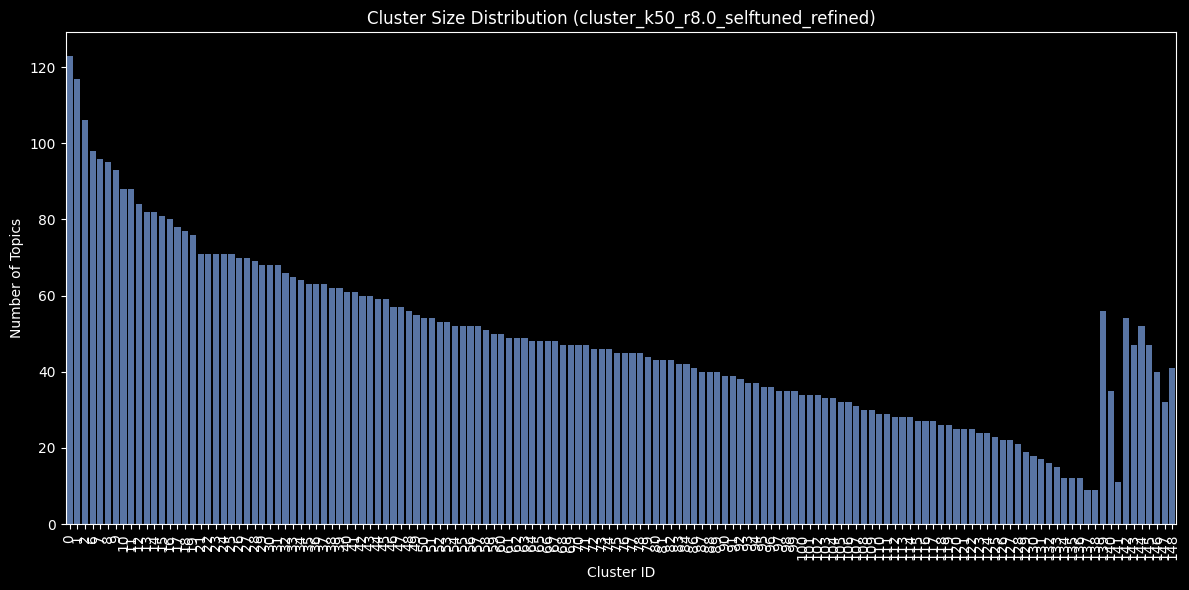

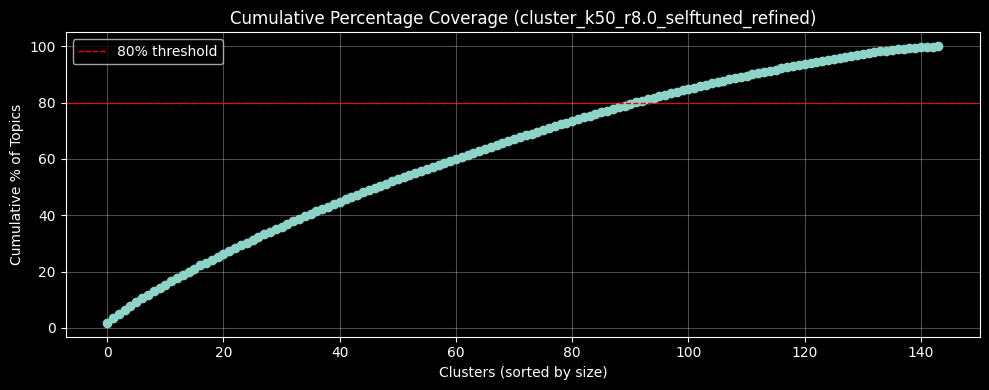

Top 5 clusters by size for cluster_k50_r8.0_selftuned_refined:
cluster_k50_r8.0_selftuned_refined
0    123
1    117
2    106
6     98
7     96
Name: count, dtype: int64


In [83]:
# Cluster size diagram (bar + cumulative)
import matplotlib.pyplot as plt
import seaborn as sns

# Resolve cluster label column robustly
cluster_cols = [c for c in topics2.columns if c.startswith('cluster_')]
if 'label_col' in globals() and label_col in topics2.columns:
    _cluster_col = label_col
elif cluster_cols:
    # choose the first with >1 unique or fallback to last
    multi = [c for c in cluster_cols if topics2[c].nunique() > 1]
    _cluster_col = multi[-1] if multi else cluster_cols[-1]
else:
    raise ValueError('No cluster_* columns found in topics DataFrame.')

counts = topics2[_cluster_col].value_counts().sort_values(ascending=False)
cluster_ids = counts.index.tolist()
cluster_sizes = counts.values
pct = cluster_sizes / cluster_sizes.sum() * 100

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=cluster_ids, y=cluster_sizes, ax=ax, color='#4C72B0')
ax.set_title(f'Cluster Size Distribution ({_cluster_col})')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Number of Topics')
#ax.bar_label(ax.containers[0], labels=[f'{v}\n({p:.1f}%)' for v, p in zip(cluster_sizes, pct)], padding=3, fontsize=8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Cumulative coverage plot
cum = pct.cumsum()
fig2, ax2 = plt.subplots(figsize=(10,4))
ax2.plot(range(len(cum)), cum, marker='o')
ax2.axhline(80, color='red', linestyle='--', linewidth=1, label='80% threshold')
ax2.set_title(f'Cumulative Percentage Coverage ({_cluster_col})')
ax2.set_xlabel('Clusters (sorted by size)')
ax2.set_ylabel('Cumulative % of Topics')
ax2.grid(alpha=0.3)
ax2.legend()
plt.tight_layout()
plt.show()

print(f'Top 5 clusters by size for {_cluster_col}:')
print(counts.head())

## Save clusters 

In [87]:
#Save data

file_path = 'C:\\Users\\Denis_Davydov2\\OneDrive - EPAM\\Prophet_AI_docs\\Datasets\\AI_skills\\Clusters\\'
file_name = f'{cluster_col_name}_items.csv'

topics2.to_csv(file_path + file_name, index=False)
print(f"File {file_name} uploaded: ", date.today())
print(topics2.shape)


file_name = f'{cluster_col_name}_clusters.csv'
df_cluster_composition_refined.to_csv(file_path + file_name, index=False)
print(f"File {file_name} uploaded: ", date.today())
print(df_cluster_composition_refined.shape)



File cluster_k50_r8.0_selftuned_items.csv uploaded:  2025-11-12
(6971, 11)
File cluster_k50_r8.0_selftuned_clusters.csv uploaded:  2025-11-12
(144, 12)


In [85]:
df_cluster_composition_refined

,cluster_id,cluster_size,avg_distance,std_distance,min_distance,max_distance,avg_dist_to_center,centroid,closest_5_members,members,members_cleaned,cleaned_size
0,0,123,0.4369,0.1003,0.0074,0.7597,0.2472,llm usage,"[llm usage, llm application, llm application d...","[llm usage, llm application, llm application d...","[audio llms, code generation (llms), code gene...",123
1,1,117,0.6215,0.1497,0.0369,1.1895,0.3805,amazon web services (aws),"[amazon web services (aws), amazon ebs, amazon...","[amazon web services (aws), amazon ebs, amazon...","[alexa, alexa integration, alexa skill develop...",115
2,2,106,0.6026,0.1492,0.0156,1.1144,0.3651,agent,"[agent, agent-to-agent communication, agent2ag...","[agent, agent-to-agent communication, agent2ag...","[a2a protocol, action, action agent, agent, ag...",105
3,6,98,0.5829,0.1401,0.0489,1.1817,0.3496,data handling,"[data handling, dataset management, dataset pr...","[data handling, dataset management, dataset pr...","[ai data management, data acquisition, data ag...",97
4,7,96,0.5201,0.1950,0.0121,1.0739,0.3034,8-bit quantization,"[8-bit quantization, int8 quantization, quanti...","[8-bit quantization, int8 quantization, quanti...","[1-bit inference, 1-bit llm, 1-bit quantizatio...",96
...,...,...,...,...,...,...,...,...,...,...,...,...
131,136,12,0.2578,0.1945,0.0216,0.7389,0.1261,mcp (model control protocol),"[mcp (model control protocol), model context p...","[mcp (model control protocol), model context p...","[mcp (model context protocol), mcp (model cont...",12
130,135,12,0.2344,0.1601,0.0384,0.6244,0.1139,no-code development,"[no-code development, no-code ai development, ...","[no-code development, no-code ai development, ...","[design-to-code, low-code ai, low-code develop...",12
136,141,11,0.4085,0.1703,0.0446,0.8095,0.2071,ai risk management,"[ai risk management, risk management, risk ass...","[ai risk management, risk management, risk ass...","[ai risk assessment, ai risk management, credi...",11
132,137,9,0.4127,0.1361,0.0246,0.6465,0.2043,gans (generative adversarial networks),"[gans (generative adversarial networks), gener...","[gans (generative adversarial networks), gener...","[conditional gan, cyclegan, dcgan, gail, gans ...",9


# UMAP Depricated

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import umap
import hdbscan

# ========================= UMAP + HDBSCAN Utilities ========================= #
# Цель: подготовка матрицы, понижение размерности UMAP и кластеризация HDBSCAN
# Дополнительно: перераспределение шума по косинусной близости центроидов.


def prepare_matrix_from_df(df: pd.DataFrame, column: str = "embedding_dehub") -> np.ndarray:
    """Извлекает список эмбеддингов из DataFrame в numpy-массив (n_samples, d).

    Допускает хранение как list или np.ndarray в ячейках.
    """
    X = df[column].values
    if isinstance(X[0], list):
        X = np.array(X, dtype=np.float32)
    else:
        X = np.stack(X).astype(np.float32)
    return X


def run_umap(
    X: np.ndarray,
    n_components: int = 30,
    n_neighbors: int = 50,
    min_dist: float = 0.1,
    random_state: int | None = 42,
    n_jobs: int | None = None,
) -> tuple[umap.UMAP, np.ndarray]:
    """Запускает UMAP для понижения размерности.

    Предупреждение "n_jobs overridden to 1" возникает когда задан random_state.
    Логика:
      - Если random_state не None (детерминизм), принудительно n_jobs=1.
      - Если random_state None, используем переданный n_jobs (или все ядра, если None).
    metric='cosine' — обычно хорошо подходит для нормированных эмбеддингов.
    Возвращает (fitted_reducer, U).
    """
    if random_state is not None:
        effective_n_jobs = 1  # детерминизм важнее параллельности
    else:
        # Если пользователь не указал, берем все доступные потоки
        effective_n_jobs = n_jobs if n_jobs is not None else -1  # -1 = все ядра в UMAP>=0.5*

    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="cosine",
        random_state=random_state,
        low_memory=True,
        verbose=False,
        n_jobs=effective_n_jobs,
    )
    U = reducer.fit_transform(X)
    return reducer, U


def run_hdbscan(
    U: np.ndarray,
    min_cluster_size: int = 25,
    min_samples: int = 20,
    cluster_selection_epsilon: float = 0.05,
) -> hdbscan.HDBSCAN:
    """Запускает HDBSCAN на UMAP-пространстве.

    metric='euclidean' — после UMAP обычно используем евклидово расстояние.
    Возвращает обученный clusterer с атрибутами labels_, probabilities_ и др.
    """
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric="euclidean",
        cluster_selection_method="leaf",
        cluster_selection_epsilon=cluster_selection_epsilon,
        prediction_data=True,
    )
    clusterer.fit(U)
    return clusterer


def compute_centroids_cosine(X_norm: np.ndarray, labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Вычисляет L2-нормированные центроиды кластеров (кроме шума = -1).

    X_norm: уже нормированная матрица (n, d).
    labels: метки HDBSCAN/другого алгоритма (шум отмечен -1).
    Возвращает (centroids, cluster_ids). Если кластеров нет -> пустые массивы.
    """
    unique = np.unique(labels)
    cluster_ids = [k for k in unique if k != -1]
    if len(cluster_ids) == 0:
        return np.zeros((0, X_norm.shape[1]), dtype=X_norm.dtype), np.array([], dtype=int)

    centroids = []
    for k in cluster_ids:
        idx = np.where(labels == k)[0]
        c = X_norm[idx].mean(axis=0)
        cn = c / (np.linalg.norm(c) + 1e-12)  # нормируем центр для косинусной метрики
        centroids.append(cn)
    return np.vstack(centroids), np.array(cluster_ids, dtype=int)


def reassign_noise_by_cosine(
    X_norm: np.ndarray,
    labels: np.ndarray,
    threshold: float = 0.5,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Переназначает точки шума (-1) к ближайшему кластеру по косинусной близости.

    threshold: минимальная косинусная близость для переназначения.
    Возвращает (labels_final, was_reassigned, sim_to_assigned):
      - labels_final: итоговые метки
      - was_reassigned: bool-массив, какие были переназначены
      - sim_to_assigned: косинусная близость для точек шума (остальное 0)
    """
    centroids, cluster_ids = compute_centroids_cosine(X_norm, labels)
    if centroids.shape[0] == 0:
        return labels.copy(), np.zeros_like(labels, dtype=bool), np.zeros_like(labels, dtype=np.float32)

    labels_final = labels.copy()
    was_reassigned = np.zeros_like(labels, dtype=bool)
    sim_to_assigned = np.zeros_like(labels, dtype=np.float32)

    noise_idx = np.where(labels == -1)[0]
    if noise_idx.size == 0:
        return labels_final, was_reassigned, sim_to_assigned

    Xn = X_norm[noise_idx]  # уже L2-нормирован
    # косинусная близость = скалярное произведение для L2-нормированных векторов
    S = Xn @ centroids.T
    best_sim = S.max(axis=1)
    best_j = S.argmax(axis=1)

    take = best_sim >= threshold
    labels_final[noise_idx[take]] = cluster_ids[best_j[take]]
    was_reassigned[noise_idx[take]] = True
    sim_to_assigned[noise_idx] = best_sim
    return labels_final, was_reassigned, sim_to_assigned


# ----------------- Параметры по умолчанию (средние разумные) ----------------- #
umap_params = dict(
    n_components=30,  # 15–50
    n_neighbors=50,   # 30–100
    min_dist=0.1,     # 0.0–0.3
    random_state=42,  # детерминированно -> n_jobs=1
    n_jobs=None,      # если random_state None -> можно повысить параллелизм (-1 = все ядра)
)

hdbscan_params = dict(
    min_cluster_size=25,          # 10–50
    min_samples=20,               # <= min_cluster_size
    cluster_selection_epsilon=0.05,
)

noise_attach_threshold = 0.5  # порог косинусной близости для доназначения шума

In [47]:
X = prepare_matrix_from_df(topics, column="embedding_dehub").astype(np.float32)
X_norm = normalize(X, norm="l2", copy=False)

In [ ]:
# UMAP
umap_model, U = run_umap(
X_norm,
**umap_params
)

c:\Users\Denis_Davydov2\miniconda3_25\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [51]:
# HDBSCAN на UMAP-пространстве
clusterer = run_hdbscan(U, **hdbscan_params)
labels = clusterer.labels_
probs = clusterer.probabilities_
outlier_scores = clusterer.outlier_scores_

c:\Users\Denis_Davydov2\miniconda3_25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Denis_Davydov2\miniconda3_25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [52]:
# Доназначение “шума” по косинусной близости в исходном (dehub) пространстве
labels_final, was_reassigned, sim_to_assigned = reassign_noise_by_cosine(
X_norm, labels, threshold=noise_attach_threshold
)

In [55]:
for i in range(U.shape[1]):
    topics[f"umap_{i}"] = U[:, i]
    topics["cluster_hdbscan"] = labels
    topics["cluster_prob"] = probs
    topics["outlier_score"] = outlier_scores
    topics["cluster_final"] = labels_final
    topics["was_reassigned"] = was_reassigned
    topics["sim_to_assigned"] = sim_to_assigned

topics

,id,term,definition,count,similarity_to_AI,consensus_score,embedding_norm,embedding_dehub,cluster_2.0,umap_0,...,umap_20,umap_21,umap_22,umap_23,umap_24,umap_25,umap_26,umap_27,umap_28,umap_29
0,6.0,1-bit inference,1-bit inference refers to the process of runni...,2.0,0.280766,4,"[0.013369597494602203, -0.013582168146967888, ...","[-0.10377315, 0.024112597, -0.37237495, -0.070...",22,2.822479,...,7.444740,2.510308,5.630877,2.055622,3.426690,4.617864,5.549823,5.584216,5.429072,6.153295
1,7.0,1-bit llm,A 1-bit large language model (LLM) is a highly...,5.0,0.220254,4,"[0.017574984580278397, -0.004011554177850485, ...","[-0.041667353, -0.1235163, 0.33915088, -0.0217...",7,1.571336,...,7.500825,2.022825,5.411247,2.176515,3.144613,4.687750,5.500618,5.309447,5.154757,5.731061
2,9.0,1-bit quantization,1-bit quantization is an extreme model compres...,6.0,0.187808,3,"[-0.015226091258227825, 0.0012089560041204095,...","[-0.052673534, 0.017871799, -0.36147624, -0.01...",22,2.797483,...,7.447979,2.549396,5.641398,2.053063,3.430004,4.634476,5.573346,5.562485,5.411089,6.172355
3,14.0,2-bit quantization,2-bit quantization is a process that reduces t...,4.0,0.190536,4,"[-0.006645898800343275, 0.006167215760797262, ...","[-0.05830743, 0.014523482, -0.35151455, 0.0150...",22,2.804163,...,7.468654,2.574511,5.666618,2.037020,3.442588,4.613830,5.597160,5.574217,5.423141,6.179354
4,17.0,2d animation,"""2D animation"" refers to the use of artificial...",3.0,0.370161,5,"[0.008917991071939468, -0.002153154695406556, ...","[0.31390756, -0.02592274, -0.26441434, 0.10848...",50,-0.174176,...,7.311998,1.759782,5.608950,1.956339,2.583977,5.010848,5.894913,6.196818,5.330648,5.155900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6966,19003.0,zero-shot voice cloning,Zero-shot voice cloning is the task of synthes...,3.0,0.212219,4,"[-0.007965235970914364, -0.027662577107548714,...","[0.38904208, 0.0016928717, -0.1268675, -0.0348...",80,-0.015467,...,7.200196,1.893399,5.538821,1.915585,2.225580,5.002223,5.716378,5.867108,5.123934,5.145426
6967,19007.0,zero-trust security,Zero-trust security for AI/ML is an architectu...,4.0,0.419530,5,"[-0.01758248545229435, 0.059987302869558334, 0...","[-0.24598806, -0.0046496205, 0.06976296, 0.038...",80,1.291752,...,7.118108,0.739655,4.809366,1.995340,3.157713,5.078456,6.212222,6.072413,5.368612,5.026320
6968,19010.0,zero/zero++,"""Zero"" (zero-shot) refers to applying or evalu...",2.0,0.243124,4,"[-0.0007028839900158346, 0.011448170058429241,...","[0.057271093, 0.020468256, -0.22577171, -0.227...",80,1.395876,...,7.503428,1.304534,5.480947,2.195449,3.480210,4.607197,6.060250,6.262040,5.654201,5.227402
6969,19012.0,zerogpu,"Zerogpu (often stylized ""zerogpu"") refers to C...",2.0,0.299549,4,"[0.004047493916004896, 0.05906970053911209, 0....","[-0.20782912, -0.43594316, -0.291142, -0.16293...",24,1.452399,...,7.599287,1.721459,5.123528,2.162012,3.668646,4.903881,5.918372,5.566827,5.315848,5.775087


In [56]:
n_clusters = (topics["cluster_hdbscan"] >= 0).sum() and len(np.unique(topics.loc[topics["cluster_hdbscan"] >= 0, "cluster_hdbscan"]))
noise_before = (topics["cluster_hdbscan"] == -1).mean()
noise_after = (topics["cluster_final"] == -1).mean()
print(f"Кластеров (HDBSCAN): {n_clusters}")
print(f"Доля шума до доназначения: {noise_before:.3f}, после: {noise_after:.3f}")
print(topics["cluster_final"].value_counts().head(10))

Кластеров (HDBSCAN): 69
Доля шума до доназначения: 0.463, после: 0.333
cluster_final
-1     2321
 59     150
 40     150
 49     146
 10     130
 28     117
 66     115
 20     113
 38     112
 62     111
Name: count, dtype: int64


In [59]:
topics[['term', 'definition', 'count', 'similarity_to_AI',
       'cluster_2.0', 'cluster_final' ]]

,term,definition,count,similarity_to_AI,cluster_2.0,cluster_final
0,1-bit inference,1-bit inference refers to the process of runni...,2.0,0.280766,22,2
1,1-bit llm,A 1-bit large language model (LLM) is a highly...,5.0,0.220254,7,10
2,1-bit quantization,1-bit quantization is an extreme model compres...,6.0,0.187808,22,2
3,2-bit quantization,2-bit quantization is a process that reduces t...,4.0,0.190536,22,2
4,2d animation,"""2D animation"" refers to the use of artificial...",3.0,0.370161,50,61
...,...,...,...,...,...,...
6966,zero-shot voice cloning,Zero-shot voice cloning is the task of synthes...,3.0,0.212219,80,62
6967,zero-trust security,Zero-trust security for AI/ML is an architectu...,4.0,0.419530,80,57
6968,zero/zero++,"""Zero"" (zero-shot) refers to applying or evalu...",2.0,0.243124,80,-1
6969,zerogpu,"Zerogpu (often stylized ""zerogpu"") refers to C...",2.0,0.299549,24,68
